# Traditional LightGBM Regression Pipeline (GPU)

This notebook demonstrates a traditional machine learning workflow using a LightGBM Regressor with GPU acceleration. Steps covered:
1. Import libraries
2. Load and prepare dataset
3. Split into train / validation / test
4. Preprocess with StandardScaler (numeric) + OneHotEncoder (categorical)
5. Initialize GPU-enabled LGBMRegressor
6. Train with early stopping on validation set
7. Evaluate on validation and test sets
8. Visualize performance and feature importance

In [ ]:
# 1. Import Required Libraries
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

# Load environment variables from .env file
load_dotenv(override=True)

# Database connection parameters
db_params = {
    "host": os.getenv("LOCAL_HOST"),
    "user": os.getenv("LOCAL_USER"),
    "password": os.getenv("LOCAL_PW"),
    "port": os.getenv("LOCAL_PORT"),
    "dbname": os.getenv("LOCAL_DB")
}

# Display versions
print('LightGBM version:', lgb.__version__)
print('Pandas version:', pd.__version__)
print('CUDA_VISIBLE_DEVICES:', os.environ.get('CUDA_VISIBLE_DEVICES'))

# GPU check helper
gpu_test_available = False
try:
    _ = LGBMRegressor(device='gpu', n_estimators=1).fit([[0],[1]], [0,1])
    gpu_test_available = True
    print('GPU is available for LightGBM (test fit succeeded).')
except Exception as e:
    print('GPU test failed, will fall back to CPU if needed. Error:', e)


In [1]:
try:
    # Establish a connection to the database
    conn = psycopg2.connect(**db_params)
    print("Database connection successful")

    # SQL query to select all data from the golden_table in the dev schema
    sql_query = "SELECT * FROM dev.golden_table;"

    # Load the data into a pandas DataFrame
    df = pd.read_sql_query(sql_query, conn)
    df = df.drop(columns=['school_name'])


    # Close the database connection
    conn.close()

    # Display the first few rows of the DataFrame
    print("Golden table loaded into DataFrame:")
    print(df.info())

except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: name 'psycopg2' is not defined


In [58]:
# 3. Split Data into Train, Validation, and Test Sets
# 60% train, 20% validation, 20% test

# Identify target if not already defined
TARGET = 'math_high_pct' if 'math_high_pct' in df.columns else 'target'

# Drop rows with missing target
data = df.dropna(subset=[TARGET]).reset_index(drop=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22507 entries, 0 to 22506
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   school_type             22507 non-null  object 
 1   enrollment              22338 non-null  float64
 2   grade_eight_enrollment  21244 non-null  float64
 3   math_counts             22507 non-null  float64
 4   math_high_pct           22507 non-null  float64
 5   math_low_pct            19960 non-null  float64
 6   read_counts             22265 non-null  float64
 7   read_high_pct           22265 non-null  float64
 8   read_low_pct            19830 non-null  float64
 9   pct_hhi_150k_200k       22507 non-null  float64
 10  pct_hhi_220k_plus       22507 non-null  float64
 11  avg_natwalkind          22507 non-null  float64
 12  total_pop               22507 non-null  int64  
 13  hhi_150k_200k           22507 non-null  int64  
 14  hhi_220k_plus           22507 non-null

In [62]:


# Build feature list excluding target
feature_cols = [c for c in data.columns if c != TARGET]

X = data[feature_cols]
y = data[TARGET]

# First split: train_temp (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42
)
# Second split: validation (20%) and test (20%) relative to original
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f'Train shape: {X_train.shape}, Validation shape: {X_valid.shape}, Test shape: {X_test.shape}')

# 4. Create Preprocessing Pipeline with StandardScaler
# Separate numeric and categorical columns
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
# Treat pandas 'category' and object as categorical
categorical_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

# Debug: show unique counts for categoricals
for c in categorical_features:
    nunique = X_train[c].nunique(dropna=False)
    print(f"  -> {c}: {nunique} unique values")

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Compatibility block for OneHotEncoder dense output across sklearn versions
ohe = OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[
    ('onehot', ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Quick diagnostic to ensure transformer works
try:
    sample_encoded = preprocessor.fit_transform(X_train.head(5))
    if hasattr(preprocessor.named_transformers_['cat'].named_steps['onehot'], 'get_feature_names_out'):
        cat_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    else:
        cat_names = []
    num_count = len(numeric_features)
    print(f"Encoded sample shape: {sample_encoded.shape} (num cols {num_count} + cat ohe {len(cat_names)})")
except Exception as e:
    print('Preprocessor diagnostic failed:', e)

print('Preprocessor defined.')

Train shape: (13504, 16), Validation shape: (4501, 16), Test shape: (4502, 16)
Numeric features: ['enrollment', 'grade_eight_enrollment', 'math_counts', 'math_low_pct', 'read_counts', 'read_high_pct', 'read_low_pct', 'pct_hhi_150k_200k', 'pct_hhi_220k_plus', 'avg_natwalkind', 'total_pop', 'hhi_150k_200k', 'hhi_220k_plus', 'schools_in_zip', 'dup_rank']
Categorical features: ['school_type']
  -> school_type: 4 unique values
Encoded sample shape: (5, 16) (num cols 15 + cat ohe 1)
Preprocessor defined.


In [ ]:
# 5. Initialize LightGBM Regressor for GPU
lgb_params = {
    'objective': 'regression',
    'n_estimators': 2000,
    'learning_rate': 0.03,
    'num_leaves': 63,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'device': 'gpu' if gpu_test_available else 'cpu'
}

model = LGBMRegressor(**lgb_params)
print(model)

In [72]:
# 6. Early Stopping Training (correct eval_set handling)
# Problem encountered: providing raw (untransformed) X_valid to lgbm__eval_set inside a Pipeline caused
# LightGBM to see object dtypes (e.g., 'school_type'). The Pipeline only transforms the main X argument,
# NOT the eval_set elements passed through **fit_params.
# Fix: Fit the preprocessor first, transform train/validation, then train the LGBM model directly with
# transformed matrices. Afterwards, wrap the fitted preprocessor + model into a Pipeline for uniform API.

# 6a. Fit preprocessor separately
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_valid_enc = preprocessor.transform(X_valid)

print('Transformed shapes -> train:', X_train_enc.shape, 'valid:', X_valid_enc.shape)

# 6b. Train LightGBM with early stopping on transformed data
callbacks = [
    lgb.early_stopping(stopping_rounds=100, verbose=True),
    lgb.log_evaluation(period=50)
]
model.fit(
    X_train_enc,
    y_train,
    eval_set=[(X_valid_enc, y_valid)],
    eval_metric='rmse',
    callbacks=callbacks
)

best_iter = model.best_iteration_
print('Best iteration detected by early stopping:', best_iter)

# 6c. Build a Pipeline wrapper holding the already-fitted preprocessor + model for downstream usage
from sklearn.base import BaseEstimator, TransformerMixin

# Mark preprocessor as already fitted; we won't refit when wrapping.
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('lgbm', model)
])

print('Pipeline constructed with fitted preprocessor and model.')

Transformed shapes -> train: (13504, 19) valid: (4501, 19)
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 13504, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.21 MB) transferred to GPU in 0.008051 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.088789
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 11.4735	valid_0's l2: 131.641
[50]	valid_0's rmse: 11.4735	valid_0's l2: 131.641
[100]	valid_0's rmse: 9.59438	valid_0's l2: 92.0521
[100]	valid_0's rmse: 9.59438	valid_0's l2: 92.0521
[150]	valid_0's rmse: 9.42345	valid_0's l2: 88.8014
[150]	valid_0's rmse: 9.42345	valid_0

In [74]:
# (Replaced: no direct fit here; model already trained with early stopping above)
print('Model already trained with early stopping; proceed to evaluation cell.')

Model already trained with early stopping; proceed to evaluation cell.


In [75]:
# 7. Make Predictions on Validation and Test Sets
y_valid_pred = pipeline.predict(X_valid)
y_test_pred = pipeline.predict(X_test)

# 8. Evaluate Model Performance
def regression_metrics(y_true, y_pred, label=''):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'label': label, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

val_metrics = regression_metrics(y_valid, y_valid_pred, 'Validation')
test_metrics = regression_metrics(y_test, y_test_pred, 'Test')

metrics_df = pd.DataFrame([val_metrics, test_metrics])
display(metrics_df)

c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,label,RMSE,MAE,R2
0,Validation,9.377527,4.727643,0.866859
1,Test,9.013905,4.562951,0.878284


Validation residual mean -0.0276, std 9.3775
Validation residual skew -1.6394
Validation residual kurtosis 13.1077


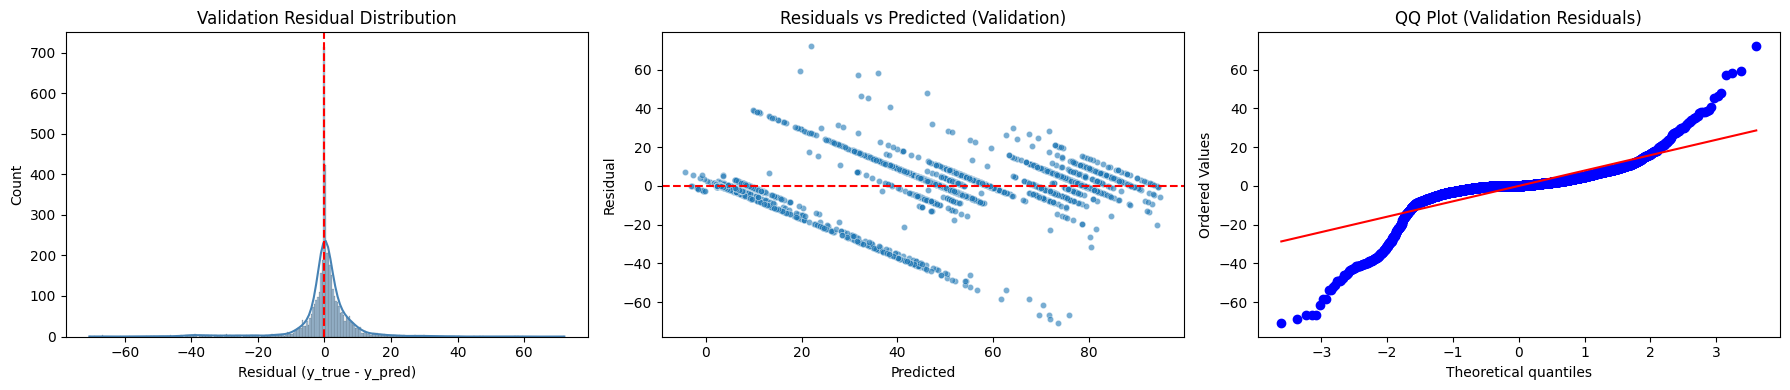

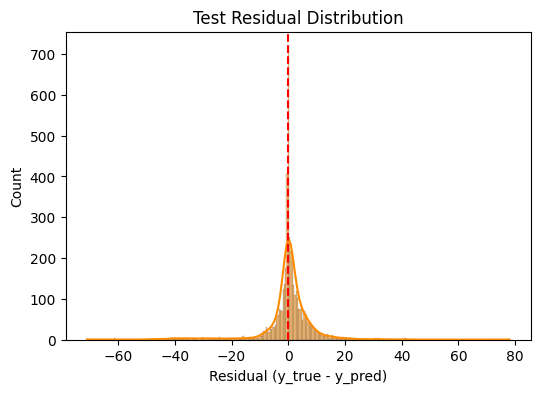

In [86]:
# Analysis 1: Residual Diagnostics (Validation & Test)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
try:
    from scipy import stats
    _has_scipy = True
except Exception:
    _has_scipy = False

res_val = y_valid - y_valid_pred
res_test = y_test - y_test_pred
std_val = np.std(res_val)
mean_val = np.mean(res_val)
print(f"Validation residual mean {mean_val:.4f}, std {std_val:.4f}")
print(f"Validation residual skew {pd.Series(res_val).skew():.4f}")
print(f"Validation residual kurtosis {pd.Series(res_val).kurtosis():.4f}")

fig, axes = plt.subplots(1,3, figsize=(18,4))
sns.histplot(res_val, kde=True, ax=axes[0], color='steelblue')
axes[0].axvline(0,color='red',ls='--')
axes[0].set_title('Validation Residual Distribution')
axes[0].set_xlabel('Residual (y_true - y_pred)')
sns.scatterplot(x=y_valid_pred, y=res_val, ax=axes[1], s=20, alpha=0.6)
axes[1].axhline(0,color='red',ls='--')
axes[1].set_title('Residuals vs Predicted (Validation)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residual')
if _has_scipy:
    stats.probplot(res_val, dist='norm', plot=axes[2])
    axes[2].set_title('QQ Plot (Validation Residuals)')
else:
    axes[2].text(0.5,0.5,'scipy not installed\nQQ plot skipped', ha='center', va='center')
    axes[2].set_axis_off()
plt.tight_layout()
plt.show()

# Test set residual histogram
plt.figure(figsize=(6,4))
sns.histplot(res_test, kde=True, color='darkorange')
plt.axvline(0,color='red',ls='--')
plt.title('Test Residual Distribution')
plt.xlabel('Residual (y_true - y_pred)')
plt.show()

C:\Users\Leo\AppData\Local\Temp\ipykernel_30004\4041138923.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = analysis_df.groupby('bin_true').agg(\


,bin_true,count,mean_true,mean_pred,rmse_bin,mae_bin,bias
0,"(-3.001, 3.0]",726,2.812672,9.607038,14.894306,6.960332,6.794365
1,"(3.0, 9.0]",455,7.769231,12.893933,12.814761,5.791883,5.124702
2,"(9.0, 49.0]",2020,48.458911,46.927298,6.286590,3.449404,-1.531612
3,"(49.0, 59.0]",521,58.424184,54.796853,6.345715,4.566151,-3.627331
4,"(59.0, 79.0]",581,75.118761,73.991403,7.009094,4.524181,-1.127358


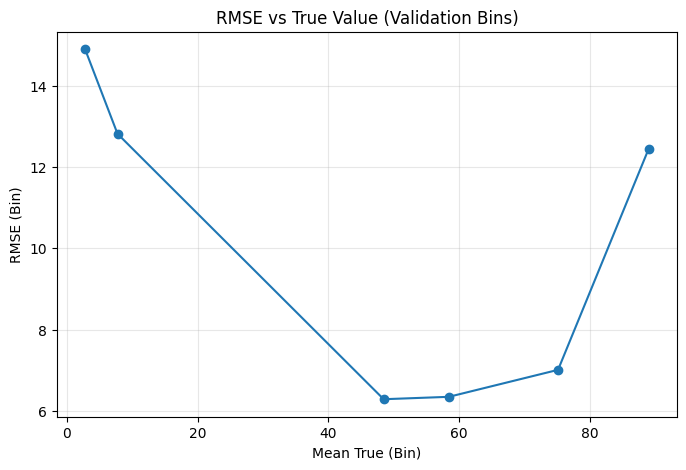

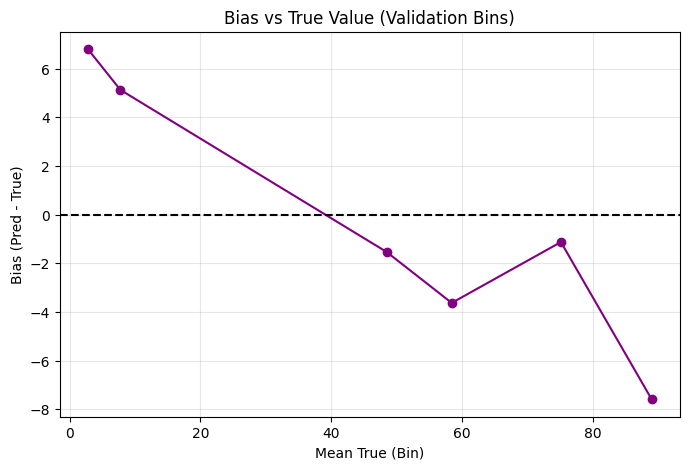

In [78]:
# Analysis 2: Error vs Target / Binned Performance
import pandas as pd
analysis_df = pd.DataFrame({'y_true_val': y_valid, 'y_pred_val': y_valid_pred})
analysis_df['abs_err'] = (analysis_df.y_true_val - analysis_df.y_pred_val).abs()
analysis_df['squared_err'] = (analysis_df.y_true_val - analysis_df.y_pred_val)**2
analysis_df['bin_true'] = pd.qcut(analysis_df.y_true_val, q=10, duplicates='drop')
bin_stats = analysis_df.groupby('bin_true').agg(\
    count=('y_true_val','size'),\
    mean_true=('y_true_val','mean'),\
    mean_pred=('y_pred_val','mean'),\
    rmse_bin=('squared_err', lambda s: sqrt(s.mean())),\
    mae_bin=('abs_err','mean')\
)\
    .reset_index()
bin_stats['bias'] = bin_stats.mean_pred - bin_stats.mean_true
display(bin_stats.head())

plt.figure(figsize=(8,5))
plt.plot(bin_stats.mean_true, bin_stats.rmse_bin, marker='o')
plt.xlabel('Mean True (Bin)')
plt.ylabel('RMSE (Bin)')
plt.title('RMSE vs True Value (Validation Bins)')
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(bin_stats.mean_true, bin_stats.bias, marker='o', color='purple')
plt.axhline(0,color='black',ls='--')
plt.xlabel('Mean True (Bin)')
plt.ylabel('Bias (Pred - True)')
plt.title('Bias vs True Value (Validation Bins)')
plt.grid(alpha=0.3)
plt.show()

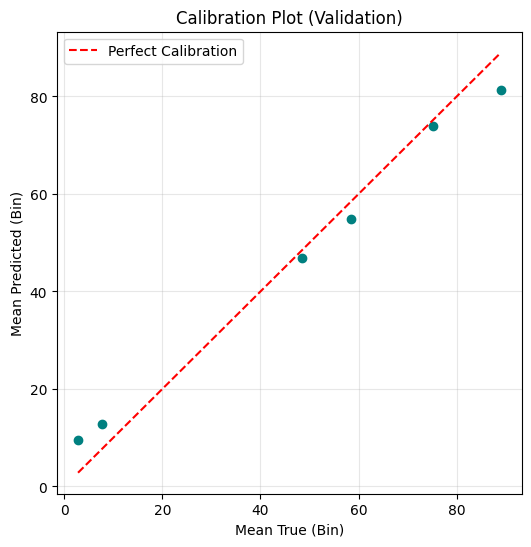

In [79]:
# Analysis 3: Calibration Curve (Regression style via bin mean predicted vs true)
# Reuse bin_stats from previous cell; if missing (cell not run), recompute quickly.
if 'bin_stats' not in globals():
    analysis_df = pd.DataFrame({'y_true_val': y_valid, 'y_pred_val': y_valid_pred})
    analysis_df['bin_true'] = pd.qcut(analysis_df.y_true_val, q=10, duplicates='drop')
    bin_stats = analysis_df.groupby('bin_true').agg(\
        mean_true=('y_true_val','mean'),\
        mean_pred=('y_pred_val','mean')\
)\
        .reset_index()

plt.figure(figsize=(6,6))
plt.scatter(bin_stats.mean_true, bin_stats.mean_pred, color='teal')
lims = [min(bin_stats.mean_true.min(), bin_stats.mean_pred.min()), max(bin_stats.mean_true.max(), bin_stats.mean_pred.max())]
plt.plot(lims, lims, 'r--', label='Perfect Calibration')
plt.xlabel('Mean True (Bin)')
plt.ylabel('Mean Predicted (Bin)')
plt.title('Calibration Plot (Validation)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [80]:
# Analysis 4: Prediction Interval Approximation (Empirical)
"""
We approximate simple empirical prediction intervals by:
1. Computing residuals on validation set.
2. Assuming residual distribution is stationary for test set.
3. Using quantiles of validation residuals to form PI on test predictions.
This is NOT a formal conformal guarantee but gives a quick uncertainty sense.
"""
import numpy as np
residual_quantiles = np.quantile(res_val, [0.025, 0.25, 0.5, 0.75, 0.975])
q_low, q25, q50, q75, q_high = residual_quantiles
print('Residual quantiles (validation):')
print({'2.5%': q_low, '25%': q25, '50%': q50, '75%': q75, '97.5%': q_high})

test_pred_lower = y_test_pred + q_low
test_pred_upper = y_test_pred + q_high

coverage = ((y_test >= test_pred_lower) & (y_test <= test_pred_upper)).mean()
print(f'Approx 95% PI empirical coverage on test: {coverage:.3f}')

# Plot a sample of intervals
sample_idx = np.random.choice(len(y_test), size=min(200, len(y_test)), replace=False)
plt.figure(figsize=(8,5))
plt.errorbar(y_test_pred.iloc[sample_idx], y_test.iloc[sample_idx],\
             yerr=[(y_test.iloc[sample_idx]-test_pred_lower.iloc[sample_idx]),\
                   (test_pred_upper.iloc[sample_idx]-y_test.iloc[sample_idx])],\
             fmt='o', alpha=0.5, ecolor='gray', capsize=2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Sample Prediction Intervals (Test)')
lims = [min(y_test_pred.min(), y_test.min()), max(y_test_pred.max(), y_test.max())]
plt.plot(lims, lims, 'r--')
plt.tight_layout()
plt.show()

Residual quantiles (validation):
{'2.5%': -29.164098319846655, '25%': -1.1269137284706154, '50%': 0.11555090903695664, '75%': 2.638683023971055, '97.5%': 15.662384717600403}
Approx 95% PI empirical coverage on test: 0.953


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

<Figure size 800x500 with 0 Axes>

Top features for error analysis: ['math_low_pct', 'grade_eight_enrollment', 'read_low_pct', 'math_counts', 'enrollment']


C:\Users\Leo\AppData\Local\Temp\ipykernel_30004\3927676535.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = num_val_df.groupby(f+'_bin').agg(mean_f=(f,'mean'), mae=('abs_err','mean'), count=('abs_err','size')).reset_index()


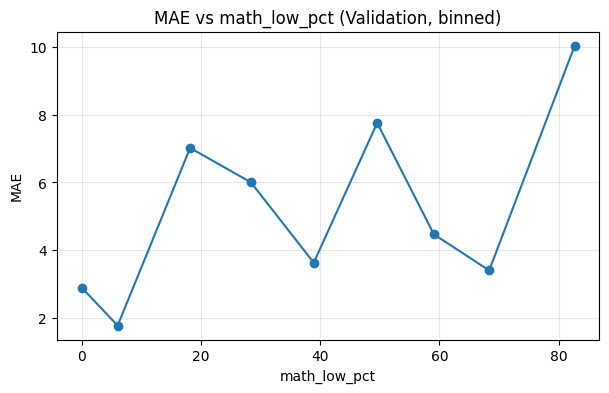

C:\Users\Leo\AppData\Local\Temp\ipykernel_30004\3927676535.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = num_val_df.groupby(f+'_bin').agg(mean_f=(f,'mean'), mae=('abs_err','mean'), count=('abs_err','size')).reset_index()


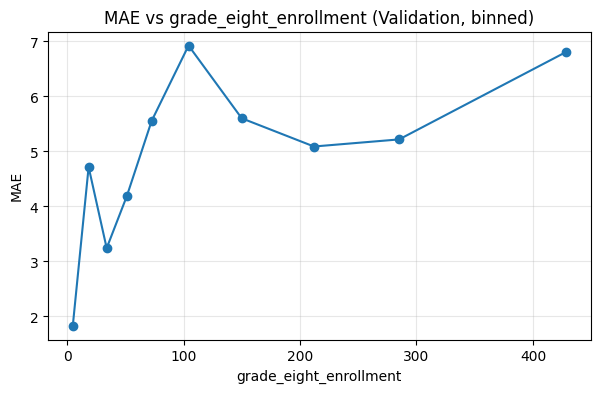

C:\Users\Leo\AppData\Local\Temp\ipykernel_30004\3927676535.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = num_val_df.groupby(f+'_bin').agg(mean_f=(f,'mean'), mae=('abs_err','mean'), count=('abs_err','size')).reset_index()


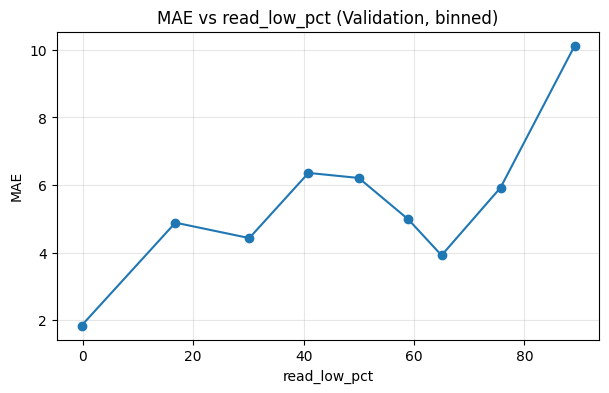

C:\Users\Leo\AppData\Local\Temp\ipykernel_30004\3927676535.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = num_val_df.groupby(f+'_bin').agg(mean_f=(f,'mean'), mae=('abs_err','mean'), count=('abs_err','size')).reset_index()


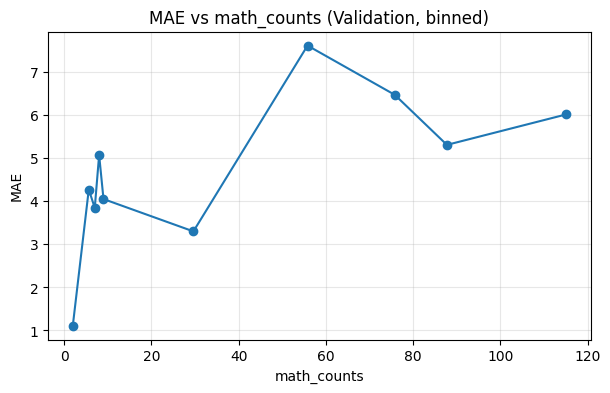

C:\Users\Leo\AppData\Local\Temp\ipykernel_30004\3927676535.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = num_val_df.groupby(f+'_bin').agg(mean_f=(f,'mean'), mae=('abs_err','mean'), count=('abs_err','size')).reset_index()


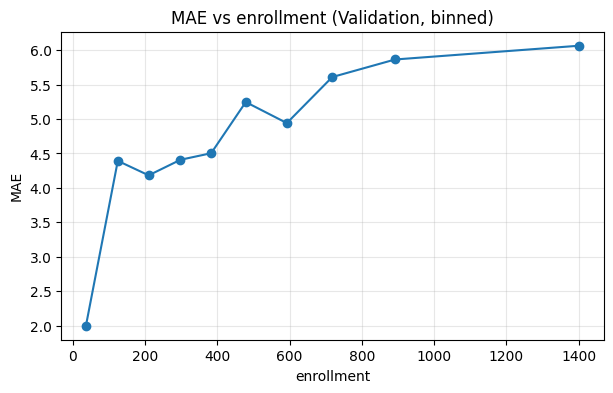

In [82]:
# Analysis 5: Feature Impact vs Error
"""
For the top N important features, examine how prediction error varies across their value ranges.
Categorical: group by category. Numeric: bin into quantiles.
"""
topN = 5
if 'imp_df' not in globals():
    # Reconstruct feature importances if not already present
    onehot = pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'] if categorical_features else None
    num_feature_names = numeric_features
    cat_feature_names = onehot.get_feature_names_out(categorical_features).tolist() if onehot is not None else []
    all_feature_names = num_feature_names + cat_feature_names
    importances = pipeline.named_steps['lgbm'].feature_importances_
    imp_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances}) \
        .sort_values('importance', ascending=False)
top_features = imp_df.head(topN).feature.tolist()
print('Top features for error analysis:', top_features)

# Get transformed validation design matrix to map back numeric columns only for distribution checks.
# For categorical OHE features, we'll skip drill-down here due to complexity of inverse mapping.
val_matrix = pipeline.named_steps['preprocess'].transform(X_valid)
val_pred = y_valid_pred
val_err = y_valid - y_valid_pred

# Create a DataFrame only for numeric original features to relate error (approx)
num_val_df = X_valid[numeric_features].copy()
num_val_df['err'] = val_err
num_val_df['abs_err'] = val_err.abs()
plots_made = 0
for f in top_features:
    if f in numeric_features:
        # Bin numeric feature
        try:
            num_val_df[f+'_bin'] = pd.qcut(num_val_df[f], q=10, duplicates='drop')
            grp = num_val_df.groupby(f+'_bin').agg(mean_f=(f,'mean'), mae=('abs_err','mean'), count=('abs_err','size')).reset_index()
            plt.figure(figsize=(7,4))
            plt.plot(grp.mean_f, grp.mae, marker='o')
            plt.xlabel(f)
            plt.ylabel('MAE')
            plt.title(f'MAE vs {f} (Validation, binned)')
            plt.grid(alpha=0.3)
            plt.show()
            plots_made += 1
        except Exception as e:
            print(f'Skipping feature {f} for error plot:', e)
if plots_made == 0:
    print('No numeric top features available for error vs value plotting.')

In [89]:
# Comparison: Predicted vs Actual for Validation and Test Sets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

# Build tidy comparison DataFrame
comparison_val = pd.DataFrame({
    'set': 'validation',
    'y_true': y_valid.reset_index(drop=True),
    'y_pred': y_valid_pred.reset_index(drop=True)
})
comparison_test = pd.DataFrame({
    'set': 'test',
    'y_true': y_test.reset_index(drop=True),
    'y_pred': y_test_pred.reset_index(drop=True)
})
comparison = pd.concat([comparison_val, comparison_test], axis=0).reset_index(drop=True)
comparison['residual'] = comparison.y_true - comparison.y_pred
comparison['abs_error'] = comparison.residual.abs()
comparison['pct_error'] = comparison['abs_error'] / comparison['y_true'].replace(0, pd.NA) * 100

# Summary metrics per set
summary = comparison.groupby('set').agg(
    count=('y_true','size'),
    mean_true=('y_true','mean'),
    mean_pred=('y_pred','mean'),
    rmse=('residual', lambda r: sqrt((r**2).mean())),
    mae=('abs_error','mean'),
    mean_pct_err=('pct_error','mean'),
    median_pct_err=('pct_error','median')
).reset_index()
display(summary)

# Parity (Actual vs Predicted) plot for both sets
plt.figure(figsize=(6,6))
sns.scatterplot(data=comparison, x='y_true', y='y_pred', hue='set', alpha=0.6, s=40)
lims = [min(comparison.y_true.min(), comparison.y_pred.min()), max(comparison.y_true.max(), comparison.y_pred.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel('Actual math_high_pct')
plt.ylabel('Predicted math_high_pct')
plt.title('Predicted vs Actual (Validation & Test)')
plt.legend()
plt.tight_layout()
plt.show()

# Residual distribution comparison
plt.figure(figsize=(7,4))
sns.kdeplot(data=comparison, x='residual', hue='set', fill=True, common_norm=False, alpha=0.4)
plt.axvline(0,color='black',ls='--')
plt.title('Residual Density by Set')
plt.xlabel('Residual (y_true - y_pred)')
plt.tight_layout()
plt.show()

# Error vs True value (both sets)
plt.figure(figsize=(7,4))
sns.scatterplot(data=comparison, x='y_true', y='residual', hue='set', alpha=0.5, s=30)
plt.axhline(0,color='black',ls='--')
plt.xlabel('Actual math_high_pct')
plt.ylabel('Residual')
plt.title('Residuals vs Actual (Validation & Test)')
plt.tight_layout()
plt.show()

# Distribution of actual vs predicted per set
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
for ax, subset, title in zip(axes, ['validation','test'], ['Validation','Test']):
    sub = comparison[comparison.set==subset]
    sns.kdeplot(sub.y_true, ax=ax, label='Actual', fill=True, alpha=0.3)
    sns.kdeplot(sub.y_pred, ax=ax, label='Predicted', fill=True, alpha=0.3)
    ax.set_title(f'Distribution: {title}')
    ax.set_xlabel('math_high_pct')
    ax.legend()
plt.tight_layout()
plt.show()

comparison.head()

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,set,RMSE,MAE,MAPE%,R2,Adj_R2,ExplainedVar
0,validation,9.377527,4.727643,52.921858,0.866859,0.866294,0.866860
1,test,9.013905,4.562951,48.835755,0.878284,0.877768,0.878286


,set,residual_mean,residual_std,residual_skew,residual_kurtosis
0,validation,-0.027594,9.378528,-1.639382,13.107695
1,test,0.035690,9.014836,-1.721964,14.112169


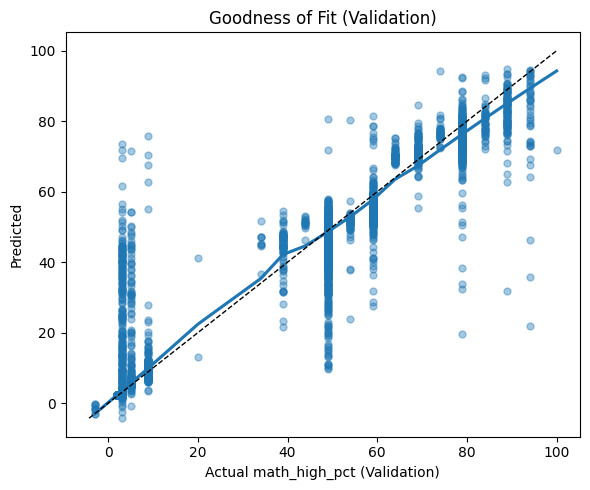

Attempting derived ROC (treating top quartile as positive)...


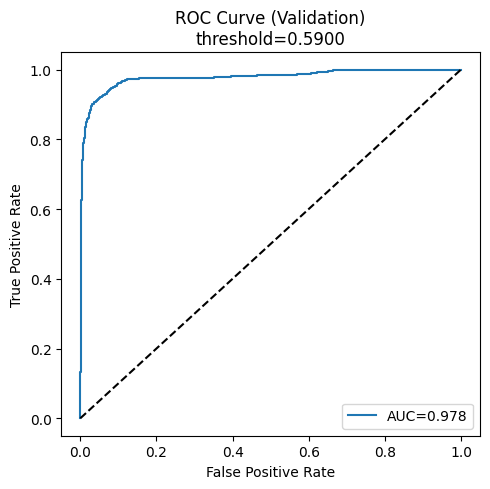

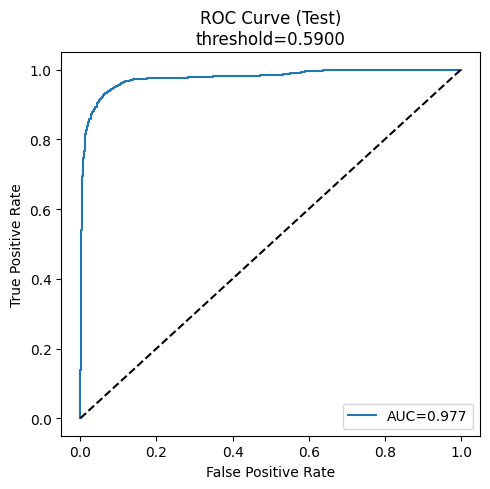

{'validation_auc': 0.9776070570080423, 'test_auc': 0.9765728960712446}


In [90]:
# Goodness of Fit Summary (Regression) + Optional ROC (derived classification)
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we have validation predictions (already computed earlier)
y_true_val = y_valid
y_pred_val = y_valid_pred
y_true_test = y_test
y_pred_test = y_test_pred

def regression_report(y_true, y_pred, label):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / np.where(y_true==0, np.nan, y_true))).mean() * 100
    r2 = r2_score(y_true, y_pred)
    # Adjusted R2: 1 - (1-R2)*(n-1)/(n-p-1)  (approx p = number of features after preprocessing)
    n = len(y_true)
    # Attempt to infer p from model; fallback to 0 if unavailable
    try:
        p = pipeline.named_steps['lgbm'].n_features_
    except Exception:
        # Approximate from transformed matrix
        try:
            p = pipeline.named_steps['preprocess'].transform(X_train.iloc[:1]).shape[1]
        except Exception:
            p = 0
    adj_r2 = 1 - (1 - r2) * (n - 1) / max(1, n - p - 1)
    return {
        'set': label,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE%': mape,
        'R2': r2,
        'Adj_R2': adj_r2,
        'ExplainedVar': explained_variance_score(y_true, y_pred)
    }

reg_metrics = pd.DataFrame([
    regression_report(y_true_val, y_pred_val, 'validation'),
    regression_report(y_true_test, y_pred_test, 'test')
])
display(reg_metrics)

# Residual summary
residuals_val = y_true_val - y_pred_val
residuals_test = y_true_test - y_pred_test
res_summary = pd.DataFrame({
    'set': ['validation','test'],
    'residual_mean': [residuals_val.mean(), residuals_test.mean()],
    'residual_std': [residuals_val.std(), residuals_test.std()],
    'residual_skew': [pd.Series(residuals_val).skew(), pd.Series(residuals_test).skew()],
    'residual_kurtosis': [pd.Series(residuals_val).kurtosis(), pd.Series(residuals_test).kurtosis()]
})
display(res_summary)

# Actual vs Predicted with smoothing (validation)
plt.figure(figsize=(6,5))
sns.regplot(x=y_true_val, y=y_pred_val, lowess=True, scatter_kws={'alpha':0.4, 's':25})
lims = [min(y_true_val.min(), y_pred_val.min()), max(y_true_val.max(), y_pred_val.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel('Actual math_high_pct (Validation)')
plt.ylabel('Predicted')
plt.title('Goodness of Fit (Validation)')
plt.tight_layout()
plt.show()

# Optional ROC: Create a derived binary target from math_high_pct
def compute_roc(y_true_cont, y_pred_cont, threshold=None, quantile=None, assume_percent=True, plot_label='Validation'):
    """
    Convert continuous target to binary (>= threshold -> 1 else 0) then compute ROC.
    If threshold is None and quantile provided, threshold = y_true_cont.quantile(quantile).
    If both None, default quantile=0.75.
    assume_percent: if True and max>1, divide by 100 for threshold logic only.
    """
    y_series = pd.Series(y_true_cont)
    preds = pd.Series(y_pred_cont)
    scale_factor = 100.0 if (assume_percent and y_series.max() <= 1.5 and y_series.min() >= 0) else 1.0
    # Detect if values look like percentages 0-1; if so we won't divide further
    if assume_percent and y_series.max() > 1.5:
        scale_factor = 1.0  # Already looks 0-100
    y_work = y_series.copy()
    # Normalize for threshold decision (not altering original)
    if scale_factor == 1.0 and y_work.max() > 1.5:
        # Probably 0-100; convert to 0-1 for thresholding convenience
        y_norm = y_work / 100.0
    else:
        y_norm = y_work
    if threshold is None and quantile is None:
        quantile = 0.75
    if quantile is not None and threshold is None:
        threshold = y_norm.quantile(quantile)
    # Binary labels
    y_bin = (y_norm >= threshold).astype(int)
    if y_bin.nunique() < 2:
        print(f'Cannot compute ROC for {plot_label}: only one class after threshold {threshold:.4f}')
        return None
    fpr, tpr, _ = roc_curve(y_bin, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({plot_label})\nthreshold={threshold:.4f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return roc_auc

print("Attempting derived ROC (treating top quartile as positive)...")
auc_val = compute_roc(y_true_val, y_pred_val, quantile=0.75, plot_label='Validation')
auc_test = compute_roc(y_true_test, y_pred_test, quantile=0.75, plot_label='Test')
print({'validation_auc': auc_val, 'test_auc': auc_test})

## Predicted vs True Values Plot Interpretation
The predicted vs true (parity) scatter plot is a primary diagnostic for regression models. Use it to assess:
- Alignment: Points hugging the 45° diagonal (y = x) indicate accurate predictions.
- Bias: A consistent vertical shift above/below the line suggests systematic over- or under-prediction.
- Heteroscedasticity: A funnel shape (residual spread growing with the target value) can signal variance changes the model hasn't captured.
- Non-linearity: Curved patterns relative to the diagonal may mean missing interaction or non-linear terms.
- Clustering: Distinct bands or clusters can reflect categorical structure or segmentation in the data.

Guidelines:
1. Ideally, residuals (vertical distance to the line) are symmetrically distributed around zero across the full range.
2. If extreme true values show larger error, consider feature engineering or transforming the target.
3. If you see saturation (predictions capped), allow deeper trees or adjust regularization.
4. Combine with residual vs predicted plots and calibration curves for a full view.

Below is an enhanced parity plot combining both validation and test sets with residual magnitude coloring.

In [ ]:
# Enhanced Parity Plot (Validation & Test) with Residual Coloring
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
val_df = pd.DataFrame({'set':'validation','y_true':y_valid,'y_pred':y_valid_pred})
test_df = pd.DataFrame({'set':'test','y_true':y_test,'y_pred':y_test_pred})
parity_df = pd.concat([val_df,test_df], ignore_index=True)
parity_df['residual'] = parity_df.y_true - parity_df.y_pred
parity_df['abs_residual'] = parity_df.residual.abs()

plt.figure(figsize=(7,6))
# Use a combined scatter with hue by set and size by absolute residual
sizes = 40 + 120 * (parity_df['abs_residual'] / (parity_df['abs_residual'].max() + 1e-9))
sns.scatterplot(data=parity_df, x='y_true', y='y_pred', hue='set', size=sizes, sizes=(20,160), alpha=0.55, edgecolor='none')
lims = [min(parity_df.y_true.min(), parity_df.y_pred.min()), max(parity_df.y_true.max(), parity_df.y_pred.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel('Actual math_high_pct')
plt.ylabel('Predicted math_high_pct')
plt.title('Parity Plot with Residual Magnitude (Point Size)')
plt.xlim(lims)
plt.ylim(lims)
plt.tight_layout()
plt.show()

# Residual magnitude distribution
plt.figure(figsize=(6,4))
sns.histplot(parity_df.abs_residual, bins=30, kde=True, color='slateblue')
plt.xlabel('Absolute Residual')
plt.title('Distribution of Absolute Residuals (Validation + Test)')
plt.tight_layout()
plt.show()

parity_df.head()

In [83]:
# 8b. Refit on Train+Validation using best iteration and save final pipeline
from sklearn.base import clone
import joblib

best_iter = pipeline.named_steps['lgbm'].best_iteration_
if best_iter is None:
    # Fallback if early stopping didn't trigger
    best_iter = pipeline.named_steps['lgbm'].n_estimators
print(f"Using best iteration for refit: {best_iter}")

# Combine train + validation for final training
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

# Clone original pipeline to avoid mutating the early-stopped instance
refit_pipeline = clone(pipeline)
refit_pipeline.named_steps['lgbm'].set_params(n_estimators=best_iter)

# Fit WITHOUT early stopping callbacks now
refit_pipeline.fit(X_train_full, y_train_full)

# Evaluate on hold-out test set
final_test_pred = refit_pipeline.predict(X_test)
final_test_rmse = mean_squared_error(y_test, final_test_pred, squared=False)
final_test_mae = mean_absolute_error(y_test, final_test_pred)
final_test_r2 = r2_score(y_test, final_test_pred)
print(f"Final Refit Test Metrics -> RMSE: {final_test_rmse:.4f}  MAE: {final_test_mae:.4f}  R2: {final_test_r2:.4f}")

# Persist full pipeline (preprocessing + trained model)
model_filename = 'lgbm_math_pipeline.pkl'
joblib.dump(refit_pipeline, model_filename)
print(f"Saved final pipeline to {model_filename}")

Using best iteration for refit: 242
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2363
[LightGBM] [Info] Number of data points in the train set: 18005, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.27 MB) transferred to GPU in 0.002376 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.156679
Final Refit Test Metrics -> RMSE: 8.8689  MAE: 4.4644  R2: 0.8822
Saved final pipeline to lgbm_math_pipeline.pkl
Final Refit Test Metrics -> RMSE: 8.8689  MAE: 4.4644  R2: 0.8822
Saved final pipeline to lgbm_math_pipeline.pkl


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


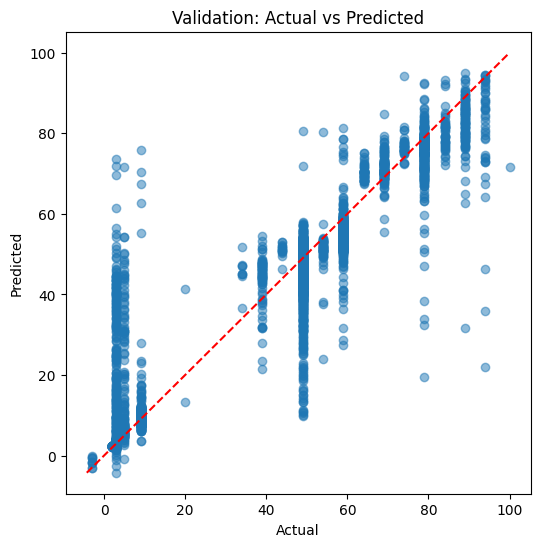

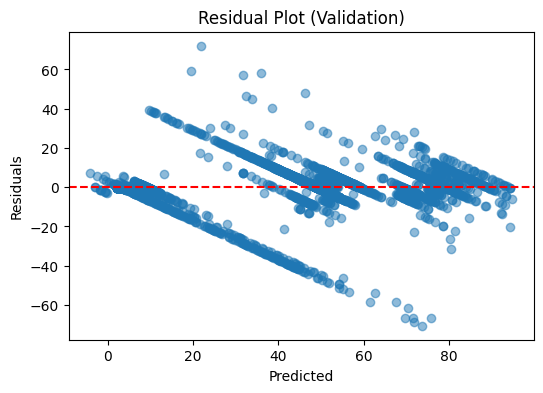

C:\Users\Leo\AppData\Local\Temp\ipykernel_30004\2489334193.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')


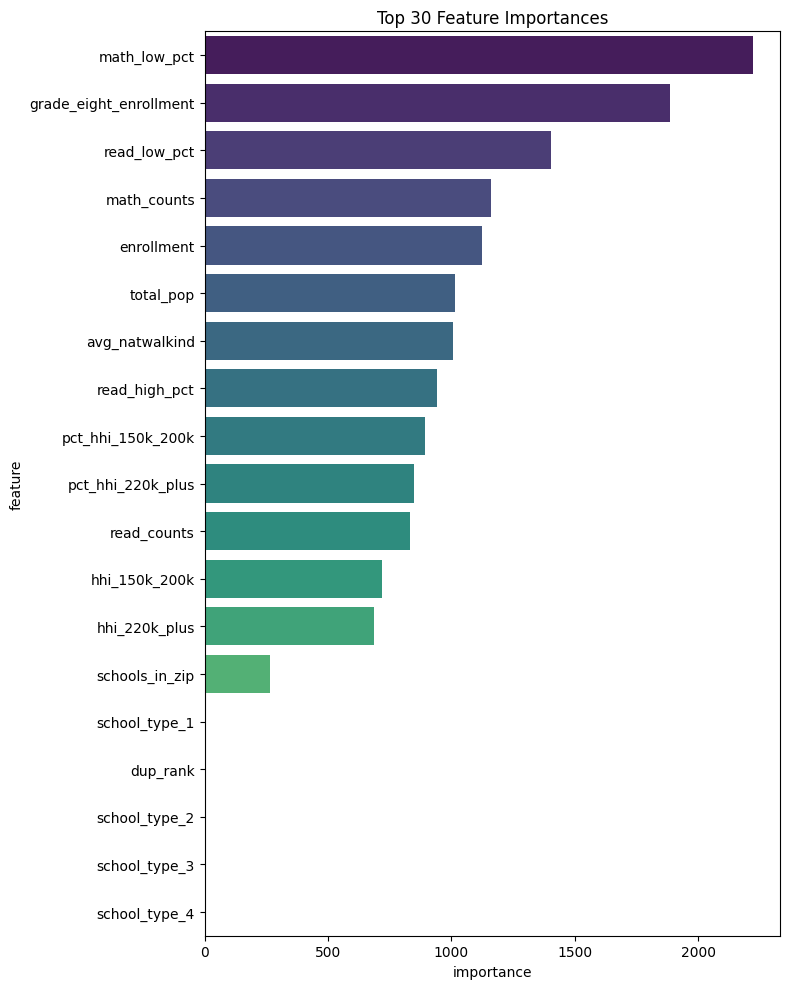

,feature,importance
3,math_low_pct,2221
1,grade_eight_enrollment,1886
6,read_low_pct,1405
2,math_counts,1160
0,enrollment,1123


In [84]:
# 9. Visualize Results and Feature Importance
# Prediction vs Actual (Validation)
plt.figure(figsize=(6,6))
plt.scatter(y_valid, y_valid_pred, alpha=0.5)
lims = [min(y_valid.min(), y_valid_pred.min()), max(y_valid.max(), y_valid_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Validation: Actual vs Predicted')
plt.show()

# Residual Plot (Validation)
residuals = y_valid - y_valid_pred
plt.figure(figsize=(6,4))
plt.scatter(y_valid_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot (Validation)')
plt.show()

# Feature Importance
lgbm_model = pipeline.named_steps['lgbm']

# Get feature names after preprocessing
onehot = pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'] if categorical_features else None
num_feature_names = numeric_features
cat_feature_names = []
if onehot is not None:
    cat_feature_names = onehot.get_feature_names_out(categorical_features).tolist()
all_feature_names = num_feature_names + cat_feature_names

importances = lgbm_model.feature_importances_
imp_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances}) \
            .sort_values('importance', ascending=False).head(30)

plt.figure(figsize=(8,10))
sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')
plt.title('Top 30 Feature Importances')
plt.tight_layout()
plt.show()

imp_df.head()

In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13504 entries, 15330 to 15795
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   school_type             13504 non-null  object 
 1   enrollment              13406 non-null  float64
 2   grade_eight_enrollment  12733 non-null  float64
 3   math_counts             13504 non-null  float64
 4   math_low_pct            12033 non-null  float64
 5   read_counts             13352 non-null  float64
 6   read_high_pct           13352 non-null  float64
 7   read_low_pct            11956 non-null  float64
 8   pct_hhi_150k_200k       13504 non-null  float64
 9   pct_hhi_220k_plus       13504 non-null  float64
 10  avg_natwalkind          13504 non-null  float64
 11  total_pop               13504 non-null  int64  
 12  hhi_150k_200k           13504 non-null  int64  
 13  hhi_220k_plus           13504 non-null  int64  
 14  schools_in_zip          13504 non-null 

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1930
[LightGBM] [Info] Number of data points in the train set: 675, number of used features: 15
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.01 MB) transferred to GPU in 0.001733 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 44.262222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction 0.05 | n=675 | train_rmse=7.3436 | valid_rmse=12.0443 | best_iter=125
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.02 MB) transferred to GPU in 0.001895 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.021481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.04 MB) transferred to GPU in 0.001369 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.484815


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction 0.20 | n=2700 | train_rmse=5.2786 | valid_rmse=10.3387 | best_iter=198
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 5401, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.08 MB) transferred to GPU in 0.001388 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.453805


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction 0.40 | n=5401 | train_rmse=6.0615 | valid_rmse=9.8376 | best_iter=208
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 8102, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.12 MB) transferred to GPU in 0.001576 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.353370


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction 0.60 | n=8102 | train_rmse=6.4565 | valid_rmse=9.7230 | best_iter=207
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2346
[LightGBM] [Info] Number of data points in the train set: 10803, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.16 MB) transferred to GPU in 0.001675 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.086457


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction 0.80 | n=10803 | train_rmse=6.5924 | valid_rmse=9.5664 | best_iter=252
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 13504, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.21 MB) transferred to GPU in 0.001648 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.088789
Fraction 1.00 | n=13504 | train_rmse=6.8699 | valid_rmse=9.3782 | best_iter=242


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,train_frac,n_samples,train_rmse,valid_rmse,best_iter
0,0.05,675,7.343560,12.044294,125
1,0.10,1350,6.561302,10.966014,145
2,0.20,2700,5.278611,10.338651,198
3,0.40,5401,6.061523,9.837610,208
4,0.60,8102,6.456490,9.722970,207
5,0.80,10803,6.592402,9.566408,252
6,1.00,13504,6.869880,9.378167,242


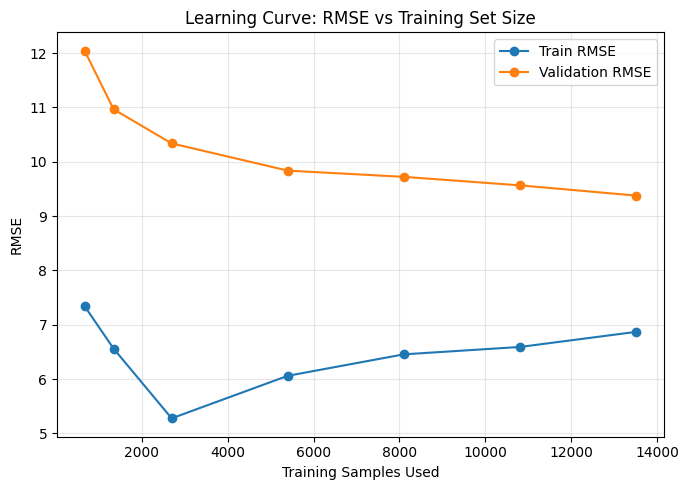

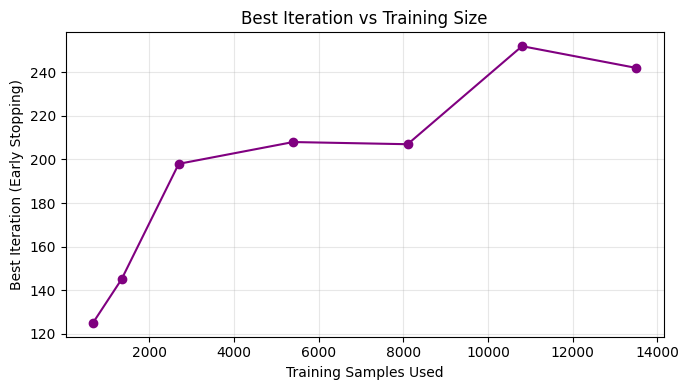

In [87]:
# Learning Curve 1: Performance vs Training Set Size (RMSE)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from copy import deepcopy
from lightgbm import LGBMRegressor
import lightgbm as lgb

# Configuration
train_size_fractions = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
min_absolute = 100  # ensure we have at least this many rows (if dataset smaller it will use available)
random_state = 42

X_train_full_base = X_train.copy()
y_train_full_base = y_train.copy()

results = []

rng = np.random.default_rng(random_state)
n_total = len(X_train_full_base)
indices_all = np.arange(n_total)

for frac in train_size_fractions:
    n_use = max(min_absolute, int(n_total * frac))
    n_use = min(n_use, n_total)
    sel_idx = rng.choice(indices_all, size=n_use, replace=False)
    X_sub = X_train_full_base.iloc[sel_idx]
    y_sub = y_train_full_base.iloc[sel_idx]
    # Fit preprocessor on subset
    preproc_local = deepcopy(preprocessor)
    # Some transformers (e.g., OneHotEncoder) already fitted; to be safe rebuild from original definitions
    # Rebuild minimal fresh preprocessor to avoid leakage from previously fitted object
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    numeric_features_local = X_sub.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features_local = X_sub.select_dtypes(include=['category','object']).columns.tolist()
    numeric_transformer_local = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer_local = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    preproc_fresh = ColumnTransformer([('num', numeric_transformer_local, numeric_features_local),('cat', categorical_transformer_local, categorical_features_local)])
    preproc_fresh.fit(X_sub)
    X_sub_enc = preproc_fresh.transform(X_sub)
    X_valid_enc_lc = preproc_fresh.transform(X_valid)
    # Model params (copy base)
    base_params = deepcopy(lgb_params)
    base_params['n_estimators'] = 4000  # allow enough boosting rounds for early stopping
    model_lc = LGBMRegressor(**base_params)
    callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=False)]
    model_lc.fit(X_sub_enc, y_sub, eval_set=[(X_valid_enc_lc, y_valid)], eval_metric='rmse', callbacks=callbacks)
    # Predictions
    y_sub_pred = model_lc.predict(X_sub_enc)
    y_valid_pred_lc = model_lc.predict(X_valid_enc_lc)
    # Metrics
    from sklearn.metrics import mean_squared_error
    train_rmse = mean_squared_error(y_sub, y_sub_pred, squared=False)
    valid_rmse = mean_squared_error(y_valid, y_valid_pred_lc, squared=False)
    results.append({'train_frac': frac, 'n_samples': n_use, 'train_rmse': train_rmse, 'valid_rmse': valid_rmse, 'best_iter': model_lc.best_iteration_})
    print(f"Fraction {frac:.2f} | n={n_use} | train_rmse={train_rmse:.4f} | valid_rmse={valid_rmse:.4f} | best_iter={model_lc.best_iteration_}")

lc_df = pd.DataFrame(results)
display(lc_df)

plt.figure(figsize=(7,5))
plt.plot(lc_df.n_samples, lc_df.train_rmse, marker='o', label='Train RMSE')
plt.plot(lc_df.n_samples, lc_df.valid_rmse, marker='o', label='Validation RMSE')
plt.xlabel('Training Samples Used')
plt.ylabel('RMSE')
plt.title('Learning Curve: RMSE vs Training Set Size')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(lc_df.n_samples, lc_df.best_iter, marker='o', color='purple')
plt.xlabel('Training Samples Used')
plt.ylabel('Best Iteration (Early Stopping)')
plt.title('Best Iteration vs Training Size')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2299
[LightGBM] [Info] Number of data points in the train set: 2251, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.03 MB) transferred to GPU in 0.001431 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 42.064860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Batch 1/6 | n=2251 | train_rmse=6.2877 | valid_rmse=10.5841 | best_iter=157
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 4502, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.07 MB) transferred to GPU in 0.004426 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 42.550866


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Batch 2/6 | n=4502 | train_rmse=5.4865 | valid_rmse=10.1615 | best_iter=219
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 6753, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.10 MB) transferred to GPU in 0.001983 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 42.808085


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Batch 3/6 | n=6753 | train_rmse=6.3466 | valid_rmse=9.8793 | best_iter=179
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 9004, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.14 MB) transferred to GPU in 0.003531 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 42.962350


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Batch 4/6 | n=9004 | train_rmse=6.9348 | valid_rmse=9.6495 | best_iter=166
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 11254, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.17 MB) transferred to GPU in 0.001723 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 42.983028


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Batch 5/6 | n=11254 | train_rmse=6.7633 | valid_rmse=9.5109 | best_iter=215
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 13504, number of used features: 17
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.21 MB) transferred to GPU in 0.001668 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.088789
Batch 6/6 | n=13504 | train_rmse=6.8699 | valid_rmse=9.3779 | best_iter=242


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,batch,cumulative_n,train_rmse,valid_rmse,best_iter
0,1,2251,6.287723,10.584090,157
1,2,4502,5.486465,10.161538,219
2,3,6753,6.346639,9.879346,179
3,4,9004,6.934828,9.649515,166
4,5,11254,6.763299,9.510905,215
5,6,13504,6.869880,9.377853,242


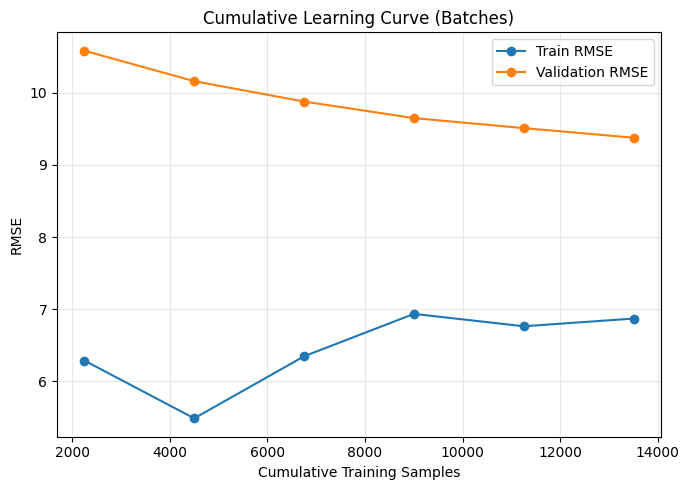

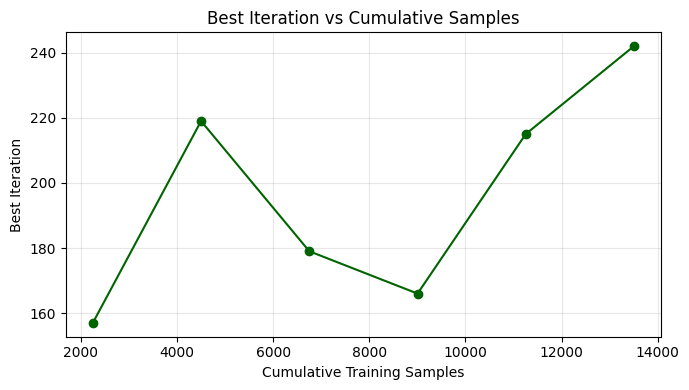

In [88]:
# Learning Curve 2: Incremental Cumulative Training (chronological shuffle fallback)
"""
If data has an implicit order (e.g., time), a cumulative learning curve can show whether more recent data still adds signal.
Here we'll just randomize (since no explicit date column is referenced) and then add batches.
"""
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import lightgbm as lgb
from math import ceil, sqrt
from copy import deepcopy
rng = np.random.default_rng(123)

# Create a shuffled index of training data
indices = np.arange(len(X_train))
rng.shuffle(indices)
batch_count = 6
batches = np.array_split(indices, batch_count)

cum_results = []
X_cum_list = []
y_cum_list = []

for i, batch in enumerate(batches, start=1):
    X_cum_list.append(X_train.iloc[batch])
    y_cum_list.append(y_train.iloc[batch])
    X_cum = pd.concat(X_cum_list)
    y_cum = pd.concat(y_cum_list)
    # Fresh preprocessing per cumulative set
    numeric_features_local = X_cum.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features_local = X_cum.select_dtypes(include=['category','object']).columns.tolist()
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    preproc_fresh = ColumnTransformer([('num', Pipeline([('scaler', StandardScaler())]), numeric_features_local), ('cat', Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features_local)])
    preproc_fresh.fit(X_cum)
    X_cum_enc = preproc_fresh.transform(X_cum)
    X_valid_enc2 = preproc_fresh.transform(X_valid)
    params = deepcopy(lgb_params)
    params['n_estimators'] = 4000
    model_cum = LGBMRegressor(**params)
    model_cum.fit(X_cum_enc, y_cum, eval_set=[(X_valid_enc2, y_valid)], eval_metric='rmse', callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])
    from sklearn.metrics import mean_squared_error
    train_rmse = mean_squared_error(y_cum, model_cum.predict(X_cum_enc), squared=False)
    val_rmse = mean_squared_error(y_valid, model_cum.predict(X_valid_enc2), squared=False)
    cum_results.append({'batch': i, 'cumulative_n': len(X_cum), 'train_rmse': train_rmse, 'valid_rmse': val_rmse, 'best_iter': model_cum.best_iteration_})
    print(f"Batch {i}/{batch_count} | n={len(X_cum)} | train_rmse={train_rmse:.4f} | valid_rmse={val_rmse:.4f} | best_iter={model_cum.best_iteration_}")

cum_df = pd.DataFrame(cum_results)
display(cum_df)

plt.figure(figsize=(7,5))
plt.plot(cum_df.cumulative_n, cum_df.train_rmse, marker='o', label='Train RMSE')
plt.plot(cum_df.cumulative_n, cum_df.valid_rmse, marker='o', label='Validation RMSE')
plt.xlabel('Cumulative Training Samples')
plt.ylabel('RMSE')
plt.title('Cumulative Learning Curve (Batches)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(cum_df.cumulative_n, cum_df.best_iter, marker='o', color='darkgreen')
plt.xlabel('Cumulative Training Samples')
plt.ylabel('Best Iteration')
plt.title('Best Iteration vs Cumulative Samples')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## PCA / Latent Structure Analysis
This section performs dimensionality reduction on the engineered feature space (after preprocessing: scaled numeric + one-hot encoded categoricals) to:
- Inspect how variance is distributed across principal components (PCs)
- Identify whether strong low-dimensional structure exists
- Surface top contributing original features to the first components
- Visualize samples in the PC1 vs PC2 plane colored by target deciles
Notes:
1. If the design matrix is high-dimensional and sparse, we automatically fall back to TruncatedSVD (PCA equivalent for sparse data).
2. Loadings help interpret which original (post-encoding) features drive each component; categorical OHE levels appear as separate indicator features.
3. Strong early variance concentration (>50% in first few PCs) may suggest redundancy or potential for dimensionality reduction in downstream models.
4. A lack of structure (very gradual variance decay) usually indicates the model benefits from many orthogonal signals.

Original matrix shape: (13504, 19) | sparse: False
Found 4192 NaNs in dense matrix; applying mean imputation.
Post-imputation type: <class 'numpy.ndarray'> | sparse: False


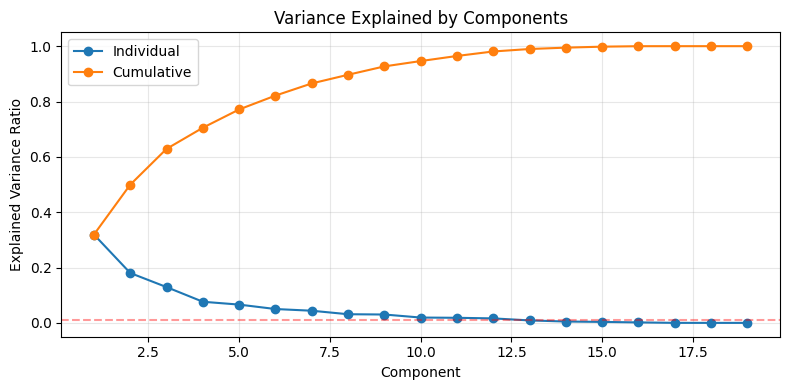

First 10 cumulative explained variance ratios:
  PC1: 0.3192
  PC2: 0.4995
  PC3: 0.6288
  PC4: 0.7052
  PC5: 0.7713
  PC6: 0.8214
  PC7: 0.8653
  PC8: 0.8966
  PC9: 0.9269
  PC10: 0.9462


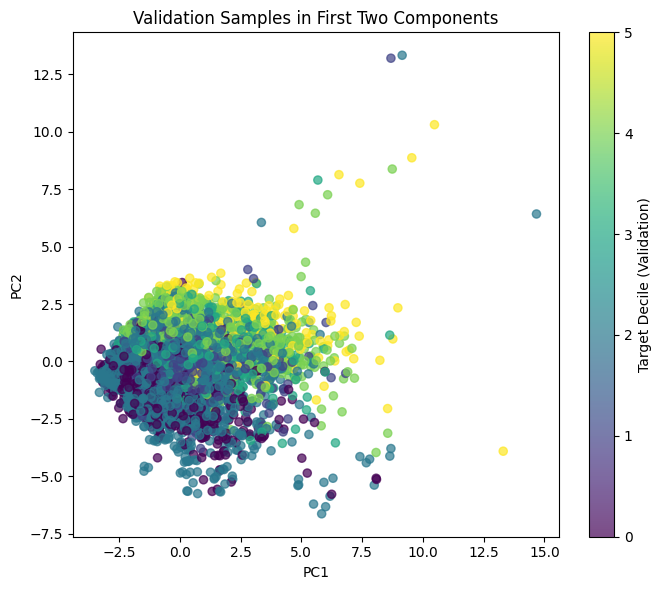


Top loadings for Component 1:
  hhi_150k_200k                            +0.4078
  hhi_220k_plus                            +0.3929
  total_pop                                +0.3167
  pct_hhi_220k_plus                        +0.3154
  pct_hhi_150k_200k                        +0.3002
  grade_eight_enrollment                   +0.2968
  enrollment                               +0.2851
  avg_natwalkind                           +0.2484
  read_low_pct                             +0.1853
  math_low_pct                             +0.1738
  math_counts                              +0.1678
  read_counts                              +0.1621

Top loadings for Component 2:
  schools_in_zip                           -0.4006
  read_counts                              +0.3447
  math_counts                              +0.3365
  read_high_pct                            +0.3271
  read_low_pct                             +0.3233
  total_pop                                -0.3132
  math_low_pct      

C:\Users\Leo\AppData\Local\Temp\ipykernel_30004\953389467.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=labels, palette='magma')


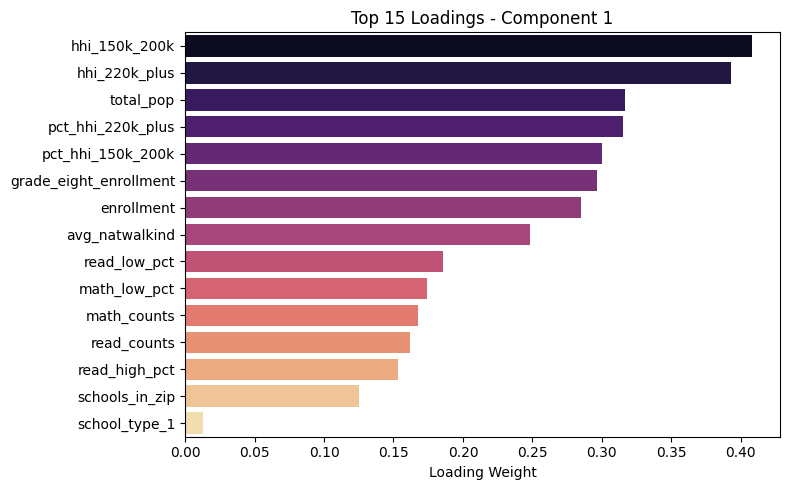

Linear model on first 10 components -> Validation RMSE: 17.1398, R2: 0.5552
Full model captures substantially more variance than low-dimensional linear projection.


c:\Users\Leo\miniconda3\envs\milestone2\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [92]:
# PCA / TruncatedSVD on Preprocessed Feature Space (with NaN handling)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
from scipy import sparse
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Obtain transformed training design matrix (already fitted preprocessor)
X_train_matrix = pipeline.named_steps['preprocess'].transform(X_train)
X_valid_matrix = pipeline.named_steps['preprocess'].transform(X_valid)
y_train_array = np.array(y_train)
y_valid_array = np.array(y_valid)

is_sparse = sparse.issparse(X_train_matrix)
print('Original matrix shape:', X_train_matrix.shape, '| sparse:', is_sparse)

# 1a. Handle NaNs before dimensionality reduction
# Count NaNs efficiently
if is_sparse:
    # For sparse, convert a small sample to check; full conversion for NaN detection may be expensive.
    # We'll impute using SimpleImputer directly which supports sparse inputs.
    pass
else:
    nan_count = np.isnan(X_train_matrix).sum()
    if nan_count > 0:
        print(f'Found {nan_count} NaNs in dense matrix; applying mean imputation.')

imputer = SimpleImputer(strategy='mean')
X_train_matrix = imputer.fit_transform(X_train_matrix)
X_valid_matrix = imputer.transform(X_valid_matrix)

# After imputation, ensure dense/sparse consistency
is_sparse = sparse.issparse(X_train_matrix)
print('Post-imputation type:', type(X_train_matrix), '| sparse:', is_sparse)

# 2. Choose dimensionality reduction method
max_components = min(50, X_train_matrix.shape[1])
if is_sparse:
    reducer = TruncatedSVD(n_components=min(25, max_components), random_state=42)
else:
    reducer = PCA(n_components=min(25, max_components), random_state=42)

reducer.fit(X_train_matrix)
explained = reducer.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(8,4))
plt.plot(range(1, len(explained)+1), explained, marker='o', label='Individual')
plt.plot(range(1, len(cum_explained)+1), cum_explained, marker='o', label='Cumulative')
plt.axhline(0.01, color='red', ls='--', alpha=0.4)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Components')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('First 10 cumulative explained variance ratios:')
for i, v in enumerate(cum_explained[:10], start=1):
    print(f'  PC{i}: {v:.4f}')

# 3. Project validation set for visualization
train_proj = reducer.transform(X_train_matrix)
valid_proj = reducer.transform(X_valid_matrix)

# Build target deciles for color mapping
val_deciles = pd.qcut(y_valid, q=10, duplicates='drop')
val_decile_codes = val_deciles.cat.codes

plt.figure(figsize=(7,6))
plt.scatter(valid_proj[:,0], valid_proj[:,1], c=val_decile_codes, cmap='viridis', s=35, alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('Target Decile (Validation)')
plt.xlabel('PC1' if not isinstance(reducer, TruncatedSVD) else 'SVD1')
plt.ylabel('PC2' if not isinstance(reducer, TruncatedSVD) else 'SVD2')
plt.title('Validation Samples in First Two Components')
plt.tight_layout()
plt.show()

# 4. Top contributing features to first two components (loadings)
onehot = None
if 'cat' in pipeline.named_steps['preprocess'].named_transformers_:
    cat_tr = pipeline.named_steps['preprocess'].named_transformers_['cat']
    if hasattr(cat_tr, 'named_steps') and 'onehot' in cat_tr.named_steps:
        onehot = cat_tr.named_steps['onehot']

numeric_feature_names = []
categorical_feature_names = []
if 'num' in pipeline.named_steps['preprocess'].named_transformers_:
    num_tr = pipeline.named_steps['preprocess'].named_transformers_['num']
    if hasattr(num_tr, 'get_feature_names_out'):
        numeric_feature_names = list(num_tr.get_feature_names_out())
    else:
        # fallback: use original numeric features list
        numeric_feature_names = list(pipeline.named_steps['preprocess'].transformers_[0][2])
if onehot is not None:
    try:
        categorical_feature_names = onehot.get_feature_names_out(categorical_features).tolist()
    except Exception:
        categorical_feature_names = []
all_feature_names = numeric_feature_names + categorical_feature_names

if hasattr(reducer, 'components_') and len(all_feature_names) == reducer.components_.shape[1]:
    comp_matrix = reducer.components_
    def top_loadings(comp_idx, top_k=12):
        comp = comp_matrix[comp_idx]
        pairs_sorted = sorted(zip(all_feature_names, comp), key=lambda x: abs(x[1]), reverse=True)[:top_k]
        return pairs_sorted
    for ci in range(min(2, comp_matrix.shape[0])):
        tl = top_loadings(ci)
        print(f'\nTop loadings for Component {ci+1}:')
        for fname, weight in tl:
            print(f'  {fname:<40s} {weight:+.4f}')
    # Bar plot for first component
    first_comp = top_loadings(0, top_k=15)
    labels = [f for f,_ in first_comp]
    weights = [w for _,w in first_comp]
    plt.figure(figsize=(8,5))
    sns.barplot(x=weights, y=labels, palette='magma')
    plt.title('Top 15 Loadings - Component 1')
    plt.xlabel('Loading Weight')
    plt.tight_layout()
    plt.show()
else:
    if not hasattr(reducer, 'components_'):
        print('Reducer does not expose components_.')
    else:
        print('Feature name length mismatch; skipping loading inspection.')

# 5. Simple regression of target on first k components (baseline check)
k = min(10, train_proj.shape[1])
reg_lr = LinearRegression()
reg_lr.fit(train_proj[:,:k], y_train_array)
val_pred_pc = reg_lr.predict(valid_proj[:,:k])
pc_rmse = mean_squared_error(y_valid_array, val_pred_pc, squared=False)
pc_r2 = r2_score(y_valid_array, val_pred_pc)
full_model_r2 = r2_score(y_valid, y_valid_pred)
print(f'Linear model on first {k} components -> Validation RMSE: {pc_rmse:.4f}, R2: {pc_r2:.4f}')
if pc_r2 + 0.05 < full_model_r2:
    print('Full model captures substantially more variance than low-dimensional linear projection.')
else:
    print('Much of the performance is captured by the first few PCs; dimensionality reduction may be viable.')